In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Activation
import os
import cv2
import numpy as np
import shutil
import random
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelBinarizer as LabelBinarizer

DEFAULTCWD = os.getcwd() +"/"
print(DEFAULTCWD)
data_folder_path = 'datasets/'
dirs = os.listdir(data_folder_path)
print(dirs)
print("READY")

Using TensorFlow backend.


D:\BigDataApps\PythonProjects\PROJECT\ML/
['guard', 'jab']
READY


## Grab data & Create labels

In [2]:
data = []
count = 0
labels = []
for pose in dirs:
    print(pose)
    fileName = os.listdir(data_folder_path + pose)
    print(fileName)
    print(data_folder_path + pose + "/" + fileName[0])
    if len(fileName) == 1:
        data.append(pd.read_csv(data_folder_path + pose + "/" + fileName[0]).values)
        for i in range(len(data[count])):
            labels.append(pose)         
    count+=1
#data[0] = pd.read_csv("datasets/jab/dataset_1591367620.csv").values
#data[1] =pd.read_csv("datasets/guard/dataset_1591367620.csv").values

guard
['dataset_1591367620.csv']
datasets/guard/dataset_1591367620.csv
jab
['dataset_1591367620.csv']
datasets/jab/dataset_1591367620.csv


#### Just for checking data types, make sure there is no strings etc

In [3]:
#### CHECKING TYPES
def checkDataTypes(dataset):
    for one in dataset:
        print(type(one))
        for two in one:
            print(type(two))
            for three in two:
                print(type(three))
                for four in three:
                    print(type(four))

## Data Formatting
The data we get is string so we'll need to parse that to float. Besides that, this method also takes care of reshaping

In [4]:

import re
def formatDataset(data):
    dataset = []  
    count = 0
    for pose in data:
        for row in pose:
            dataset.append([]) #Person (useless dimension, but needed to get 4d)
            personCount = 0
            for person in range(1):
                dataset[count].append([]) #Frame (This is the actual keypoint array (aka 1 row in the excel))
                for cell in row: # The cell is a string (aka xyc) so we'll split by comma and format each number we get 
                    #print(cell)
                    if type(cell) != float:
                        buffer = cell.split(',')
                        array = np.empty(shape=len(buffer)) # Was necessary due to it being a float or something
                        i = 0
                        for number in buffer:
                            array[i] = float(number)
                            i+=1
                        #print(array)
                        dataset[count][personCount].append(array) # Put it in the main dataset
                personCount += 1
            count += 1
    return np.array(dataset) # Parse it into a numpy array and return! 
                            #(It was a Python array in the beginning) 
                            # Reason why it's like this is due to the 'efficency' of numpy arrays makes them not able to
                            # have data appended to them, the size of the array has to be known. 
                            # But Python array is easier to work with in this case


In [5]:
ds = formatDataset(data) 
# Checking if everything has the correct type
print(type(ds))
print(len(ds))
print(type(ds[0]))
print(len(ds[0]))
print(type(ds[0][0]))
print(len(ds[0][0]))
print(type(ds[0][0][0]))

# perform "one-hot" encoding on the labels (Make label into a number but still remember the string related to the number) 
# aka enum

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

print(labels)



<class 'numpy.ndarray'>
1306
<class 'numpy.ndarray'>
1
<class 'numpy.ndarray'>
25
<class 'numpy.ndarray'>
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [6]:
# Check how the dataset looks like and if the ds length vs label lenght is matching
print(len(labels))
print(len(ds[0]))
print(ds)

1306
1
[[[[1.23068e+03 2.74199e+02 8.40742e-01]
   [1.33079e+03 3.44966e+02 7.89760e-01]
   [1.28673e+03 3.62514e+02 6.92934e-01]
   ...
   [0.00000e+00 0.00000e+00 0.00000e+00]
   [0.00000e+00 0.00000e+00 0.00000e+00]
   [1.38966e+03 1.07491e+03 6.06459e-02]]]


 [[[1.23370e+03 2.77159e+02 8.77445e-01]
   [1.33079e+03 3.53642e+02 8.20089e-01]
   [1.28667e+03 3.65571e+02 7.23462e-01]
   ...
   [0.00000e+00 0.00000e+00 0.00000e+00]
   [0.00000e+00 0.00000e+00 0.00000e+00]
   [1.38678e+03 1.07491e+03 7.21354e-02]]]


 [[[1.23379e+03 2.74246e+02 8.94704e-01]
   [1.33083e+03 3.50724e+02 8.11966e-01]
   [1.28387e+03 3.65526e+02 7.07538e-01]
   ...
   [0.00000e+00 0.00000e+00 0.00000e+00]
   [0.00000e+00 0.00000e+00 0.00000e+00]
   [1.38972e+03 1.07491e+03 8.05632e-02]]]


 ...


 [[[1.23673e+03 2.91717e+02 8.98089e-01]
   [1.33375e+03 3.68509e+02 8.39670e-01]
   [1.27494e+03 3.83121e+02 7.55099e-01]
   ...
   [1.28380e+03 1.07489e+03 1.19958e-01]
   [1.28371e+03 1.07491e+03 9.99918e-02]
   

In [7]:
# split data into train and test
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(ds, labels, test_size=0.25, stratify=labels, random_state=42)

print("SHAPES")
print("TRAIN SINGLE SHAPE: "+ str(trainX[0].shape))
print("TRAIN ARRAY SHAPE: "+str(trainX.shape))
print("TEST SINGLE SHAPE: "+ str(testX[0].shape))
print("TEST ARRAY SHAPE: "+str(testX.shape))

SHAPES
TRAIN SINGLE SHAPE: (1, 25, 3)
TRAIN ARRAY SHAPE: (979, 1, 25, 3)
TEST SINGLE SHAPE: (1, 25, 3)
TEST ARRAY SHAPE: (327, 1, 25, 3)


In [8]:
from tensorflow.keras.regularizers import l2
# CONFIGS
init = "he_normal"
reg = l2(0.0005)
inputShape = trainX[0].shape # (1,25,3)
chanDim = -1
classes = len(dirs) # len of labels (2 for now)
####



model = Sequential()

# This is mostly copied for Kim's link, I only changed the Conv2D things the example: (1,4)
# 16 FILTERS
# 7x7 filters -- 2x2 strides
# the spatial dimensions of the volume
model.add(Conv2D(16, (1, 4), strides=(2, 2), padding="valid",
    kernel_initializer=init, kernel_regularizer=reg,
    input_shape=inputShape))
# here we stack two CONV layers on top of each other where
# each layerswill learn a total of 32 (3x3) filters
model.add(Conv2D(32, (3, 3), padding="same",
    kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same",
    kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))

# stack two more CONV layers, keeping the size of each filter

# as 3x3 but increasing to 64 total learned filters
model.add(Conv2D(64, (2, 2), padding="same",
    kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (2, 6), strides=(2, 2), padding="same",
    kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))

# increase the number of filters again, this time to 128
model.add(Conv2D(128, (6, 4), padding="same",
    kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same",
    kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))

# fully-connected layer
model.add(Flatten())
model.add(Dense(512, kernel_initializer=init))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# softmax classifier
model.add(Dense(classes))
model.add(Activation("softmax"))

print("MODEL PREPARED")


MODEL PREPARED


In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
print("MODEL COMPILED")

MODEL COMPILED


In [10]:
history = model.fit(trainX, trainY, batch_size=32,
    validation_data=(testX, testY), epochs=200) # Change to 20 epochs when testing 

print("TRAINING COMPLETE")


Train on 979 samples, validate on 327 samples
Epoch 1/200
979/979 [==============================] - 2s 2ms/step - loss: 1.5383 - accuracy: 0.5516 - val_loss: 0.9851 - val_accuracy: 0.4801
Epoch 2/200
979/979 [==============================] - 1s 600us/step - loss: 1.2442 - accuracy: 0.5659 - val_loss: 0.8983 - val_accuracy: 0.4801
Epoch 3/200
979/979 [==============================] - 1s 621us/step - loss: 1.1652 - accuracy: 0.5536 - val_loss: 0.8708 - val_accuracy: 0.6116
Epoch 4/200
979/979 [==============================] - 1s 663us/step - loss: 1.0284 - accuracy: 0.6078 - val_loss: 0.8761 - val_accuracy: 0.4985
Epoch 5/200
979/979 [==============================] - 1s 633us/step - loss: 1.0148 - accuracy: 0.6098 - val_loss: 0.8427 - val_accuracy: 0.5719
Epoch 6/200
979/979 [==============================] - 1s 668us/step - loss: 0.9396 - accuracy: 0.6180 - val_loss: 0.8163 - val_accuracy: 0.6942
Epoch 7/200
979/979 [==============================] - 1s 609us/step - loss: 0.8309 - 

Epoch 57/200
979/979 [==============================] - 1s 811us/step - loss: 0.5698 - accuracy: 0.8141 - val_loss: 0.8784 - val_accuracy: 0.7370
Epoch 58/200
979/979 [==============================] - 1s 787us/step - loss: 0.5859 - accuracy: 0.8223 - val_loss: 1.4873 - val_accuracy: 0.4771 - loss: 0.5865 - accuracy: 0.82
Epoch 59/200
979/979 [==============================] - 1s 689us/step - loss: 0.5880 - accuracy: 0.8059 - val_loss: 0.6924 - val_accuracy: 0.7645
Epoch 60/200
979/979 [==============================] - 1s 695us/step - loss: 0.5712 - accuracy: 0.8182 - val_loss: 1.5701 - val_accuracy: 0.4862
Epoch 61/200
979/979 [==============================] - 1s 845us/step - loss: 0.5751 - accuracy: 0.8141 - val_loss: 0.7665 - val_accuracy: 0.6606
Epoch 62/200
979/979 [==============================] - 1s 797us/step - loss: 0.5995 - accuracy: 0.8100 - val_loss: 0.7098 - val_accuracy: 0.7339
Epoch 63/200
979/979 [==============================] - 1s 595us/step - loss: 0.5606 - accur

Epoch 113/200
979/979 [==============================] - 1s 786us/step - loss: 0.5085 - accuracy: 0.8458 - val_loss: 1.5174 - val_accuracy: 0.4801
Epoch 114/200
979/979 [==============================] - 1s 742us/step - loss: 0.5250 - accuracy: 0.8325 - val_loss: 1.2577 - val_accuracy: 0.4862
Epoch 115/200
979/979 [==============================] - 1s 711us/step - loss: 0.4993 - accuracy: 0.8335 - val_loss: 0.6698 - val_accuracy: 0.7798
Epoch 116/200
979/979 [==============================] - 1s 813us/step - loss: 0.5004 - accuracy: 0.8315 - val_loss: 0.6089 - val_accuracy: 0.7951
Epoch 117/200
979/979 [==============================] - 1s 703us/step - loss: 0.5084 - accuracy: 0.8284 - val_loss: 0.5183 - val_accuracy: 0.8318
Epoch 118/200
979/979 [==============================] - 1s 808us/step - loss: 0.5066 - accuracy: 0.8386 - val_loss: 0.6878 - val_accuracy: 0.7798
Epoch 119/200
979/979 [==============================] - 1s 722us/step - loss: 0.4797 - accuracy: 0.8488 - val_loss: 1

Epoch 169/200
979/979 [==============================] - 1s 756us/step - loss: 0.4416 - accuracy: 0.8468 - val_loss: 0.6094 - val_accuracy: 0.8043
Epoch 170/200
979/979 [==============================] - 1s 767us/step - loss: 0.4503 - accuracy: 0.8498 - val_loss: 0.5257 - val_accuracy: 0.8226
Epoch 171/200
979/979 [==============================] - 1s 813us/step - loss: 0.4444 - accuracy: 0.8447 - val_loss: 0.8126 - val_accuracy: 0.7370
Epoch 172/200
979/979 [==============================] - 1s 692us/step - loss: 0.4350 - accuracy: 0.8458 - val_loss: 0.7010 - val_accuracy: 0.7829
Epoch 173/200
979/979 [==============================] - 1s 731us/step - loss: 0.4604 - accuracy: 0.8437 - val_loss: 1.3329 - val_accuracy: 0.5138
Epoch 174/200
979/979 [==============================] - 1s 761us/step - loss: 0.4307 - accuracy: 0.8509 - val_loss: 0.8771 - val_accuracy: 0.7492
Epoch 175/200
979/979 [==============================] - 1s 789us/step - loss: 0.4437 - accuracy: 0.8366 - val_loss: 0

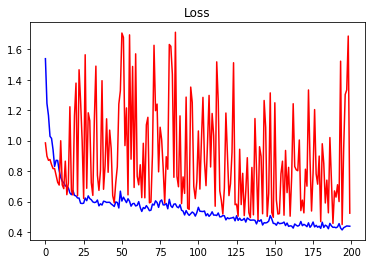

In [11]:
plt.subplot(111)
plt.title('Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='train')


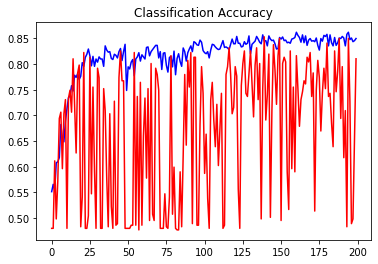

In [12]:
plt.subplot(111)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='train')

In [13]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


In [14]:
from sklearn.metrics import classification_report
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       guard       1.00      0.68      0.81       327
         jab       0.00      0.00      0.00         0

    accuracy                           0.68       327
   macro avg       0.50      0.34      0.40       327
weighted avg       1.00      0.68      0.81       327



D:\BigDataApps\Anaconda\envs\Data Science - P37 build\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
